!pip install -q transformers datasets accelerate pillow requests tqdm pandas
!pip install -q torch torchvision
!pip install -q huggingface_hub

In [29]:
!pip install -q transformers datasets accelerate pillow requests tqdm pandas
!pip install -q torch torchvision scikit-learn
!pip install -q huggingface_hub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [30]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
import json

Load quoran dataset

In [31]:
# Load the Quran dataset from Hugging Face
dataset = load_dataset("mohammed-almaamari/quran-dataset", split="train")

# Convert to pandas for easier manipulation
df = dataset.to_pandas()

print(f"Dataset loaded with {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
df.head()

Repo card metadata block was not found. Setting CardData to empty.


Dataset loaded with 6236 rows
Columns: ['audio_path', 'surah_number', 'surah_name', 'surah_english_name', 'surah_english_translation', 'revelation_type', 'aya_number', 'aya_text', 'page', 'juz_number', 'manzil', 'hizb_number', 'ruku_number', 'quarter_number', 'sajda', 'aya_image']


,audio_path,surah_number,surah_name,surah_english_name,surah_english_translation,revelation_type,aya_number,aya_text,page,juz_number,manzil,hizb_number,ruku_number,quarter_number,sajda,aya_image
0,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,1,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-1-...
1,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-2-...
2,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,3,الرَّحْمَٰنِ الرَّحِيمِ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-3-...
3,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,4,مَالِكِ يَوْمِ الدِّينِ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-4-...
4,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,5,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-5-...


dataset structure

In [32]:
print("Dataset Schema:")
print("-" * 50)
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

print("\n" + "=" * 50)
print("Sample row:")
print(df.iloc[0].to_dict())

print("\n" + "=" * 50)
print(f"Total Surahs: {df['surah_number'].nunique()}")
print(f"Total Ayahs: {len(df)}")
print(f"Revelation types: {df['revelation_type'].unique()}")

Dataset Schema:
--------------------------------------------------
audio_path: object
surah_number: int64
surah_name: object
surah_english_name: object
surah_english_translation: object
revelation_type: object
aya_number: int64
aya_text: object
page: int64
juz_number: int64
manzil: int64
hizb_number: int64
ruku_number: int64
quarter_number: int64
sajda: object
aya_image: object

Sample row:
{'audio_path': 'https://everyayah.com/data/Muhammad_Ayyoub_128kbps/001001.mp3', 'surah_number': 1, 'surah_name': 'سُورَةُ ٱلْفَاتِحَةِ', 'surah_english_name': 'Al-Faatiha', 'surah_english_translation': 'The Opening', 'revelation_type': 'Meccan', 'aya_number': 1, 'aya_text': 'بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ', 'page': 1, 'juz_number': 1, 'manzil': 1, 'hizb_number': 1, 'ruku_number': 1, 'quarter_number': 1, 'sajda': None, 'aya_image': 'https://surahquran.com/img/Ayat-green/verse-1-surah-1.png'}

Total Surahs: 114
Total Ayahs: 6236
Revelation types: ['Meccan' 'Medinan']


Testing image download: https://surahquran.com/img/Ayat-green/verse-1-surah-1.png
Success! Image size: (1080, 477)


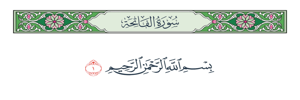

In [33]:
import hashlib

def download_image(url, cache_dir="./quran_images"):
    """Download image from URL with caching"""
    os.makedirs(cache_dir, exist_ok=True)

    # Create cache filename from URL hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    cache_path = os.path.join(cache_dir, f"{url_hash}.png")

    # Check if already cached
    if os.path.exists(cache_path):
        try:
            return Image.open(cache_path).convert("RGB")
        except:
            pass

    # Download image
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(cache_path)
        return img
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

# Test downloading a single image
test_url = df['aya_image'].iloc[0]
print(f"Testing image download: {test_url}")
test_img = download_image(test_url)
if test_img:
    print(f"Success! Image size: {test_img.size}")
    display(test_img.resize((300, 100)))

In [34]:
def create_ocr_sample(row):
    """Create an OCR training sample from a dataset row"""

    # The image shows the ayah text, model should extract it
    prompt = "<image>\nاستخرج النص القرآني من هذه الصورة."

    # The expected output is the ayah text with metadata
    response = f"""النص: {row['aya_text']}
السورة: {row['surah_name']} ({row['surah_english_name']})
رقم الآية: {row['aya_number']}
الصفحة: {row['page']}
الجزء: {row['juz_number']}
الحزب: {row['hizb_number']}"""

    if pd.notna(row['sajda']) and row['sajda']:
        response += f"\nسجدة: {row['sajda']}"

    return {
        "prompt": prompt,
        "response": response,
        "image_url": row['aya_image'],
        "surah_number": row['surah_number'],
        "aya_number": row['aya_number'],
        "aya_text": row['aya_text']
    }

# Create samples for all rows
samples = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Creating samples"):
    sample = create_ocr_sample(row)
    samples.append(sample)

print(f"Created {len(samples)} training samples")
print("\nExample sample:")
print(json.dumps(samples[0], ensure_ascii=False, indent=2))

Creating samples: 100%|██████████| 6236/6236 [00:00<00:00, 55978.51it/s]

Created 6236 training samples

Example sample:
{
  "prompt": "<image>\nاستخرج النص القرآني من هذه الصورة.",
  "response": "النص: بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ\nالسورة: سُورَةُ ٱلْفَاتِحَةِ (Al-Faatiha)\nرقم الآية: 1\nالصفحة: 1\nالجزء: 1\nالحزب: 1",
  "image_url": "https://surahquran.com/img/Ayat-green/verse-1-surah-1.png",
  "surah_number": 1,
  "aya_number": 1,
  "aya_text": "بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ"
}


In [35]:
def create_multi_task_samples(row):
    """Create multiple task variations for each ayah"""
    samples = []

    # Task 1: Simple OCR - Extract text only
    samples.append({
        "task": "ocr",
        "prompt": "<image>\nExtract the Quranic text from this image.",
        "response": row['aya_text'],
        "image_url": row['aya_image']
    })

    # Task 2: Full metadata extraction
    samples.append({
        "task": "metadata",
        "prompt": "<image>\nExtract all information from this Quran ayah image.",
        "response": f"""Ayah Text: {row['aya_text']}
Surah: {row['surah_name']} ({row['surah_english_translation']})
Surah Number: {row['surah_number']}
Ayah Number: {row['aya_number']}
Page: {row['page']}
Juz: {row['juz_number']}
Hizb: {row['hizb_number']}
Manzil: {row['manzil']}
Ruku: {row['ruku_number']}
Quarter: {row['quarter_number']}
Revelation Type: {row['revelation_type']}""",
        "image_url": row['aya_image']
    })

    # Task 3: Arabic OCR
    samples.append({
        "task": "arabic_ocr",
        "prompt": "<image>\nاقرأ النص العربي في هذه الصورة.",
        "response": row['aya_text'],
        "image_url": row['aya_image']
    })

    return samples

# Create multi-task samples for a subset
multi_task_samples = []
for idx, row in tqdm(df.head(100).iterrows(), total=100, desc="Creating multi-task samples"):
    multi_task_samples.extend(create_multi_task_samples(row))

print(f"Created {len(multi_task_samples)} multi-task samples from 100 ayahs")

Creating multi-task samples: 100%|██████████| 100/100 [00:00<00:00, 39261.48it/s]

Created 300 multi-task samples from 100 ayahs


In [36]:
def predownload_images(df, cache_dir="./quran_images", max_images=None):
    """Pre-download all images to local cache"""
    os.makedirs(cache_dir, exist_ok=True)

    urls = df['aya_image'].tolist()
    if max_images:
        urls = urls[:max_images]

    successful = 0
    failed = 0

    for url in tqdm(urls, desc="Downloading images"):
        try:
            url_hash = hashlib.md5(url.encode()).hexdigest()
            cache_path = os.path.join(cache_dir, f"{url_hash}.png")

            if os.path.exists(cache_path):
                successful += 1
                continue

            response = requests.get(url, timeout=30)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(cache_path)
            successful += 1
        except Exception as e:
            failed += 1

    print(f"Downloaded: {successful}, Failed: {failed}")
    return successful, failed

# Download first 500 images
predownload_images(df, max_images=500)

Downloaded: 500, Failed: 0


(500, 0)

In [37]:
def save_training_data(samples, output_path="quran_ocr_training.json"):
    """Save training samples to JSON format"""

    # Format for training
    training_data = []
    for sample in samples:
        training_data.append({
            "conversations": [
                {
                    "role": "<|User|>",
                    "content": sample['prompt'],
                    "images": [sample['image_url']]
                },
                {
                    "role": "<|Assistant|>",
                    "content": sample['response']
                }
            ]
        })

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(training_data, f, ensure_ascii=False, indent=2)

    print(f"Saved {len(training_data)} samples to {output_path}")
    return output_path

# Save training data
save_training_data(samples[:1000], "quran_ocr_training.json")

Saved 1000 samples to quran_ocr_training.json


'quran_ocr_training.json'

In [38]:
from sklearn.model_selection import train_test_split

# Create stratified split by surah
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['surah_number']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create samples for each split
train_samples = [create_ocr_sample(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))]
val_samples = [create_ocr_sample(row) for _, row in tqdm(val_df.iterrows(), total=len(val_df))]

# Save splits
save_training_data(train_samples, "quran_ocr_train.json")
save_training_data(val_samples, "quran_ocr_val.json")

Training samples: 5612
Validation samples: 624


100%|██████████| 624/624 [00:00<00:00, 52152.99it/s]

Saved 5612 samples to quran_ocr_train.json
Saved 624 samples to quran_ocr_val.json


'quran_ocr_val.json'

In [39]:
# Model configuration
model_path = "prithivMLmods/DeepSeek-OCR-Latest-BF16.I64"

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    trust_remote_code=True
)

print(f"Tokenizer loaded with vocab size: {tokenizer.vocab_size}")

Using device: cpu


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

Tokenizer loaded with vocab size: 128000


In [40]:
from transformers import BitsAndBytesConfig

# Quantization config for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

print("Model loaded successfully")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e9:.2f}B")

config.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/prithivMLmods/DeepSeek-OCR-Latest-BF16.I64:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/prithivMLmods/DeepSeek-OCR-Latest-BF16.I64:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/prithivMLmods/DeepSeek-OCR-Latest-BF16.I64:
- modeling_deepseekocr.py
- deepencoder.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ModuleNotFoundError: No module named 'transformers_modules.prithivMLmods.DeepSeek-OCR-Latest-BF16'

Test inference on Quran image

In [ ]:
def test_inference(model, tokenizer, image_url, prompt):
    """Run inference on a single image"""

    # Download image
    response = requests.get(image_url, timeout=30)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    # Display image
    display(image)

    # Create conversation format
    conversation = [
        {
            "role": "<|User|>",
            "content": prompt,
            "images": [image_url]
        },
        {"role": "<|Assistant|>", "content": ""}
    ]

    # Run inference using model's infer method if available
    if hasattr(model, 'infer'):
        output = model.infer(
            tokenizer=tokenizer,
            prompt=prompt,
            image_file=image_url,
            output_path="./test_output",
            eval_mode=True
        )
        return output

    return "Inference method not available"

# Test on first ayah
test_url = df['aya_image'].iloc[0]
test_prompt = "<image>\nExtract the Quranic text from this image."

print("Testing inference on first ayah:")
print(f"Expected text: {df['aya_text'].iloc[0]}")
print("-" * 50)

result = test_inference(model, tokenizer, test_url, test_prompt)
print(f"Model output: {result}")

LORA finetuning

In [ ]:
!pip install -q peft

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare model for training
model = prepare_model_for_kbit_training(model)

# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable_params:,} / {all_params:,} ({100 * trainable_params / all_params:.2f}%)")

Training config

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./quran_ocr_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    warmup_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_steps=500,
    eval_steps=500,
    evaluation_strategy="steps",
    save_total_limit=3,
    fp16=True,
    report_to="none",
    dataloader_num_workers=2,
    remove_unused_columns=False
)

print("Training configuration set")

Data collector

In [ ]:
def collate_fn(batch, tokenizer, model):
    """Custom collate function for Quran OCR dataset"""

    prompts = []
    responses = []
    images = []

    for sample in batch:
        if sample['image'] is None:
            continue

        prompts.append(sample['prompt'])
        responses.append(sample['response'])
        images.append(sample['image'])

    if not prompts:
        return None

    # Tokenize inputs
    full_texts = [f"{p}\n{r}" for p, r in zip(prompts, responses)]

    encodings = tokenizer(
        full_texts,
        padding=True,
        truncation=True,
        max_length=2048,
        return_tensors="pt"
    )

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": encodings["input_ids"].clone(),
        "images": images
    }

print("Data collator defined")

In [ ]:
from functools import partial

# Create datasets
train_dataset = QuranOCRDataset(train_samples, max_samples=1000)
val_dataset = QuranOCRDataset(val_samples, max_samples=100)

# Create collate function with tokenizer
collate_with_tokenizer = partial(collate_fn, tokenizer=tokenizer, model=model)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_with_tokenizer,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_with_tokenizer,
    num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Scheduler
num_training_steps = len(train_loader) * 3  # 3 epochs
scheduler = CosineAnnealingLR(optimizer, T_max=num_training_steps)

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        if batch is None:
            continue

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        num_batches += 1

        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / max(num_batches, 1)

print("Training functions defined")

Run training

In [ ]:
num_epochs = 3
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")

    # Evaluate
    model.eval()
    val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            if batch is None:
                continue

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss += outputs.loss.item()
            num_val_batches += 1

    val_loss = val_loss / max(num_val_batches, 1)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained("./quran_ocr_best")
        print("Saved best model!")

print("\nTraining complete!")

In [ ]:
output_dir = "./quran_ocr_finetuned_final"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

# List saved files
for f in os.listdir(output_dir):
    size = os.path.getsize(os.path.join(output_dir, f)) / 1e6
    print(f"  {f}: {size:.2f} MB")

In [ ]:
def evaluate_ocr_accuracy(model, tokenizer, test_samples, num_samples=50):
    """Evaluate OCR accuracy on test samples"""

    results = []

    for sample in tqdm(test_samples[:num_samples], desc="Evaluating"):
        try:
            # Download image
            response = requests.get(sample['image_url'], timeout=30)
            image = Image.open(BytesIO(response.content)).convert("RGB")

            # Get prediction (simplified - would need full inference pipeline)
            expected = sample['aya_text']

            results.append({
                "expected": expected,
                "image_url": sample['image_url']
            })

        except Exception as e:
            continue

    return results

# Run evaluation
eval_results = evaluate_ocr_accuracy(model, tokenizer, val_samples, num_samples=20)
print(f"Evaluated {len(eval_results)} samples")

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(sample, prediction=None):
    """Visualize a sample with its prediction"""

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    # Download and display image
    response = requests.get(sample['image_url'], timeout=30)
    image = Image.open(BytesIO(response.content))

    ax.imshow(image)
    ax.axis('off')

    # Add text below
    title = f"Surah: {sample.get('surah_number', 'N/A')}, Ayah: {sample.get('aya_number', 'N/A')}"
    ax.set_title(title, fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"Expected: {sample['aya_text']}")
    if prediction:
        print(f"Predicted: {prediction}")

# Visualize a few samples
for i in range(3):
    print(f"\n{'='*50}")
    print(f"Sample {i+1}")
    print('='*50)
    visualize_sample(samples[i])